<a href="https://colab.research.google.com/github/kyle-gao/ML_ipynb/blob/master/BERTFineTuningExperiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
##### Copyright Yi Lin(Kyle) Gao.

##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
!pip install -q tf-models-official==2.3.0                                                     l

     |████████████████████████████████| 849kB 9.5MB/s 
     |████████████████████████████████| 358kB 29.0MB/s 
     |████████████████████████████████| 1.1MB 31.1MB/s 
     |████████████████████████████████| 174kB 40.4MB/s 
     |████████████████████████████████| 102kB 12.4MB/s 
     |████████████████████████████████| 36.6MB 83kB/s 
     |████████████████████████████████| 235kB 60.1MB/s 


In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

In [3]:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/keras_bert/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)
hub_url_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2"

In [4]:
"""
Number of labels: 2.
Size of training dataset: 3668.
Size of evaluation dataset: 408.
Maximum sequence length of training and evaluation dataset: 128.
glue Microsoft research paraphrase corpus."""

glue, info = tfds.load('glue/mrpc', with_info=True,
                       # It's small, load the whole dataset
                       batch_size=-1)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/glue/mrpc/1.0.0.incomplete858SP8/glue-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/glue/mrpc/1.0.0.incomplete858SP8/glue-validation.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/glue/mrpc/1.0.0.incomplete858SP8/glue-test.tfrecord
Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/mrpc/1.0.0. Subsequent calls will reuse this data.


In [5]:
info.features
#each element in glue is a dict of with keys idx,label,sentence1,sentence2
#need to preprocess

FeaturesDict({
    'idx': tf.int32,
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'sentence1': Text(shape=(), dtype=tf.string),
    'sentence2': Text(shape=(), dtype=tf.string),
})

In [6]:
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
     do_lower_case=True)

print("Vocab size:", len(tokenizer.vocab))

Vocab size: 30522


In [12]:
def encode_sentence(s):
  tokens = list(tokenizer.tokenize(s.numpy())) #list of string tokens (words and word fragments)
  tokens.append('[SEP]')
  return tokenizer.convert_tokens_to_ids(tokens)

glue_train = glue['train']

sentence1 = tf.ragged.constant([
    encode_sentence(s) for s in glue_train["sentence1"]]) #ragged tensors are tensors of variable "lengths"
sentence2 = tf.ragged.constant([
    encode_sentence(s) for s in glue_train["sentence2"]])

In [13]:
def encode_sentence(s, tokenizer):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)
   
def bert_encode(glue_dict, tokenizer):
    #Returns a dict
    # 'input_word_ids': tokenized ids of CLS + sentence1 + SEP + sentence2
    # 'input_mask': input_mask, #padding mask up to len 103, 0s where padded
    # 'input_type_ids': input_type_ids} #mask of len 103, 0s for sentence1 or padding, 1 for sentence2

    num_examples = len(glue_dict['sentence1'])

    sentence1 = tf.ragged.constant([
      encode_sentence(s, tokenizer)
      for s in np.array(glue_dict["sentence1"])])
    sentence2 = tf.ragged.constant([
      encode_sentence(s, tokenizer)
       for s in np.array(glue_dict["sentence2"])])
    
    cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
    input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)
    #cls tells BERT its a classification task
    #sentence1, 'CLS', sentence2

    #padding pask #0s where padded, 1 where not padded, pads up sequence length of 103
    input_mask = tf.ones_like(input_word_ids).to_tensor()

    #labels 0s for input sentence1, 1 for input sentence 2
    type_cls = tf.zeros_like(cls)
    type_s1 = tf.zeros_like(sentence1)
    type_s2 = tf.ones_like(sentence2)
    input_type_ids = tf.concat([type_cls, type_s1, type_s2], axis=-1).to_tensor()

    inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids} 

    return inputs


In [324]:
glue_train = bert_encode(glue['train'], tokenizer)
glue_train_labels = glue['train']['label']

glue_validation = bert_encode(glue['validation'], tokenizer)
glue_validation_labels = glue['validation']['label']

glue_test = bert_encode(glue['test'], tokenizer)
glue_test_labels  = glue['test']['label']

In [298]:
import json

bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())

bert_config = bert.configs.BertConfig.from_dict(config_dict)

config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

In [16]:
bert_classifier, bert_encoder = bert.bert_models.classifier_model(
    bert_config, num_labels=2)

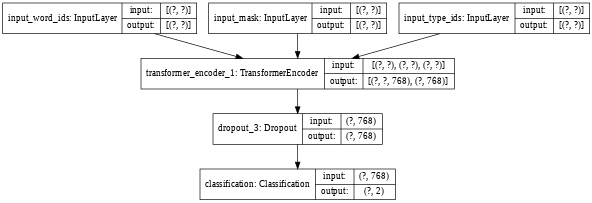

In [17]:
tf.keras.utils.plot_model(bert_classifier, show_shapes=True, dpi=48) #takes in the encoded sentence and the 2 masks as a dict

In [18]:
glue_batch = {key: val[:10] for key, val in glue_train.items()}
bert_classifier(
    glue_batch, training=True
).numpy()

array([[-0.01276865,  0.00675366],
       [-0.09909599,  0.07504182],
       [-0.05628411, -0.0542238 ],
       [ 0.05289662,  0.04070969],
       [-0.23486392,  0.07673847],
       [-0.00078663,  0.00539429],
       [ 0.03175328,  0.11529471],
       [-0.01853238,  0.11385218],
       [-0.18106887,  0.05376534],
       [-0.18105456,  0.06458932]], dtype=float32)

The bert classifier takes batched dictionary input (Expected the following keys: ['input_word_ids', 'input_mask', 'input_type_ids'])

Returns a batch of logits for classes.

In [321]:
checkpoint = tf.train.Checkpoint(model=bert_encoder)
checkpoint.restore(
    os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

In [322]:
# Set up epochs and steps

epochs = 3
batch_size = 32
eval_batch_size = 32

train_data_size = len(glue_train_labels)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

"""This is the AdamW optimizer with warmup and decay, can import for other models"""
# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [325]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

bert_classifier.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

bert_classifier.fit(
      glue_train, glue_train_labels,
      validation_data=(glue_validation, glue_validation_labels),
      batch_size=32,
      epochs=epochs)

Epoch 1/3
115/115 [==============================] - 75s 652ms/step - loss: 0.6230 - accuracy: 0.6145 - val_loss: 0.5044 - val_accuracy: 0.7598
Epoch 2/3
115/115 [==============================] - 77s 667ms/step - loss: 0.4405 - accuracy: 0.7917 - val_loss: 0.4394 - val_accuracy: 0.8137
Epoch 3/3
115/115 [==============================] - 79s 684ms/step - loss: 0.3146 - accuracy: 0.8670 - val_loss: 0.4439 - val_accuracy: 0.8260


In [327]:
input_dict = {"sentence1":["Sing, goddess, of the anger of Achilleus, son of Peleus, the accursed anger which brought uncounted anguish on the Achaians","I learned today that smoophesx has three sides.","I know that smoophesx has 3 + 1 sides.","6 apples + 6 apples","6 apples + 6 apples"],
        "sentence2":["Rage—Goddess, sing the rage of Peleus' son Achilles,murderous, doomed, that cost the Achaeans countless losses","I learned today that smoophesx has four sides.","I know that smoophesx has 4 sides.", "16 apples","12 apples"]}
#Martin's and Robert's translation of the Illiad's opening lines
#Martin's and Robert's translation of the Illiad's opening lines
#And a pair of sentence I wrote to confuse the mode
my_input = bert_encode(input_dict,tokenizer)
results = bert_classifier.predict(my_input)
probs = tf.nn.sigmoid(results)
for i in range(len(probs)):
  print(input_dict['sentence1'][i])
  print(input_dict['sentence2'][i])
  print( "matches {}%".format(tf.math.round(100*probs[i,0])))
  print()

Sing, goddess, of the anger of Achilleus, son of Peleus, the accursed anger which brought uncounted anguish on the Achaians
Rage—Goddess, sing the rage of Peleus' son Achilles,murderous, doomed, that cost the Achaeans countless losses
matches 62.0%

I learned today that smoophesx has three sides.
I learned today that smoophesx has four sides.
matches 13.0%

I know that smoophesx has 3 + 1 sides.
I know that smoophesx has 4 sides.
matches 16.0%

6 apples + 6 apples
16 apples
matches 47.0%

6 apples + 6 apples
12 apples
matches 43.0%



It is seems that the bert_classifier does understand the meaning of a sentence on some level.

Sentence pair 1 differs quite a bit in structure but has similar meaning.

Sentence pair 2 is very similar structurally, it contains an invented word; yet the model can reason that three sides != four sides.

Sentence pair 3 shows that the model does not understand addition, (at least inside a sentence). This would be interesting to replicate on a SciBERT model. 

In [48]:
variables = ["apple", "pie","elephant","x","crumpledututt","smorples","dunderbuss"]

In [86]:
length = 3668 #test_set which we will use to train bert_classifer for some addition.
randidx = np.random.permutation(range(length))

In [328]:
glue_train = glue['train']
sentence1 = glue_train['sentence1'].numpy()
sentence2 = glue_train['sentence2'].numpy()
labels = glue_train_labels.numpy()

In [317]:
summand = np.random.randint((20), size = (length,2))
sum = np.sum(summand, axis = -1)

new_sentence1 = []
new_sentence2 = []
var_num = len(variables)
#We insert the addition in place of periods or colons
#We have 0.1 chance that a variable shifts
#and about 0.3 chance that the sum ammount changes
#the label changes to 0 the sum changes by a non zero amount or at least one of the 3 variables differs from the others.

for i in range(length):
  shift1 = np.random.choice([0, 1], p=[0.9,0.1])
  shift2 = np.random.choice([0, 1], p=[0.9,0.1])
  shift3 = np.random.choice([0, 1], p=[0.9,0.1])
  var_string1 = variables[(shift1+i)%(var_num)]
  var_string2 = variables[(shift2+i)%(var_num)]
  var_string3 = variables[(shift3+i)%(var_num)]
  sum_shift = np.random.choice([0, 1], p=[0.7,0.3])*np.random.randint(0,50)


  math_string = f", {summand[i,0]} {var_string1} + {summand[i,1]} {var_string2},"
  math_string_2= f", {summand[i,0]} {var_string1} + {summand[i,1]} {var_string2}. "
  new_sentence1.append(sentence1[i].decode().replace(" ,",math_string).replace(" .",math_string_2))


  math_string = f", {sum[i]+sum_shift} {var_string3},"
  math_string_2= f", {sum[i]+sum_shift} {var_string3}. "
  new_sentence2.append(sentence2[i].decode().replace(" ,",math_string).replace(" .",math_string_2))

  #label=0 means matching sentence
  if not (shift1 == shift2 == shift3):
    labels[i]=1
  if not sum_shift == 0:
    labels[i]=1
  

In [318]:
idx=1
print(new_sentence1[idx])
print(new_sentence2[idx])
print(labels[idx])
print(f"original label {glue_train_labels[idx]}")

Less than 20 percent of Boise 's sales would come from making lumber and paper after the OfficeMax purchase is completed, 18 pie + 2 elephant. 
Less than 20 percent of Boise 's sales would come from making lumber and paper after the OfficeMax purchase is complete, 20 pie, assuming those businesses aren 't sold, 20 pie. 
1
original label 0


In [319]:
idx=33
print(new_sentence1[idx])
print(new_sentence2[idx])
print(labels[idx])
print(f"original label {glue_train_labels[idx]}")

A passer-by found Ben hiding along a dirt road in Spanish Fork Canyon about 7 p.m., 15 smorples + 19 smorples, with his hands still taped together but his feet free, 15 smorples + 19 smorples. 
A passer-by found the boy hiding along a dirt road in Spanish Fork Canyon about 7 p.m. Thursday, 81 smorples, with his feet free but his hands still taped, 81 smorples. 
1
original label 1


In [329]:
glue_dict = {"sentence1": new_sentence1,"sentence2": new_sentence2}
new_train = bert_encode(glue_dict,tokenizer)

In [330]:
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)
bert_classifier.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)
bert_classifier.fit(
      new_train, labels,
      validation_data=(glue_validation, glue_validation_labels),
      batch_size=32,
      epochs=epochs)

Epoch 1/3
115/115 [==============================] - 163s 1s/step - loss: 0.3374 - accuracy: 0.8486 - val_loss: 0.3848 - val_accuracy: 0.8309
Epoch 2/3
115/115 [==============================] - 164s 1s/step - loss: 0.2113 - accuracy: 0.9177 - val_loss: 0.4326 - val_accuracy: 0.8554
Epoch 3/3
115/115 [==============================] - 164s 1s/step - loss: 0.1242 - accuracy: 0.9588 - val_loss: 0.4471 - val_accuracy: 0.8480


In [331]:
input_dict = {"sentence1":["Sing, goddess, of the anger of Achilleus, son of Peleus, the accursed anger which brought uncounted anguish on the Achaians","I learned today that smoophesx has three sides.","I know that smoophesx has 3 + 1 sides.","6 apples + 6 apples","6 apples + 6 apples"],
        "sentence2":["Rage—Goddess, sing the rage of Peleus' son Achilles,murderous, doomed, that cost the Achaeans countless losses","I learned today that smoophesx has four sides.","I know that smoophesx has 4 sides.", "16 apples","12 apples"]}
#Martin's and Robert's translation of the Illiad's opening lines
#And a pair of sentence I wrote to confuse the mode
my_input = bert_encode(input_dict,tokenizer)
results = bert_classifier.predict(my_input)
probs = tf.nn.sigmoid(results)
for i in range(len(probs)):
  print(input_dict['sentence1'][i])
  print(input_dict['sentence2'][i])
  print( "matches {}%".format(tf.math.round(100*probs[i,0])))
  print()

Sing, goddess, of the anger of Achilleus, son of Peleus, the accursed anger which brought uncounted anguish on the Achaians
Rage—Goddess, sing the rage of Peleus' son Achilles,murderous, doomed, that cost the Achaeans countless losses
matches 66.0%

I learned today that smoophesx has three sides.
I learned today that smoophesx has four sides.
matches 7.0%

I know that smoophesx has 3 + 1 sides.
I know that smoophesx has 4 sides.
matches 8.0%

6 apples + 6 apples
16 apples
matches 40.0%

6 apples + 6 apples
12 apples
matches 30.0%



It looks like the effort was wasted. In retrospect the dataset we tried to teach addition on was too hacked togheter. SciBERT might offer better pretraining for mathematics.